# Dry Bean

The source can be found [here](https://archive.ics.uci.edu/ml/datasets/Dry+Bean+Dataset).

## Data Set Information:

Seven different types of dry beans were used in this research, taking into account the features such as form, shape, type, and structure by the market situation. A computer vision system was developed to distinguish seven different registered varieties of dry beans with similar features in order to obtain uniform seed classification. For the classification model, images of 13,611 grains of 7 different registered dry beans were taken with a high-resolution camera. Bean images obtained by computer vision system were subjected to segmentation and feature extraction stages, and a total of 16 features; 12 dimensions and 4 shape forms, were obtained from the grains.


Attribute Information:

01. Area (A): The area of a bean zone and the number of pixels within its boundaries.
02. Perimeter (P): Bean circumference is defined as the length of its border.
03. Major axis length (L): The distance between the ends of the longest line that can be drawn from a bean.
04. Minor axis length (l): The longest line that can be drawn from the bean while standing perpendicular to the main axis.
05. Aspect ratio (K): Defines the relationship between L and l.
06. Eccentricity (Ec): Eccentricity of the ellipse having the same moments as the region.
07. Convex area (C): Number of pixels in the smallest convex polygon that can contain the area of a bean seed.
08. Equivalent diameter (Ed): The diameter of a circle having the same area as a bean seed area.
09. Extent (Ex): The ratio of the pixels in the bounding box to the bean area.
10. Solidity (S): Also known as convexity. The ratio of the pixels in the convex shell to those found in beans.
11. Roundness (R): Calculated with the following formula: (4piA)/(P^2)
12. Compactness (CO): Measures the roundness of an object: Ed/L
13. ShapeFactor1 (SF1)
14. ShapeFactor2 (SF2)
15. ShapeFactor3 (SF3)
16. ShapeFactor4 (SF4)
17. Class (Seker, Barbunya, Bombay, Cali, Dermosan, Horoz and Sira)

## Imports

In [199]:
import re  # Regex

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_predict, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

## Global parameters setup

In [200]:
# @formatter:off
%matplotlib inline
# @formatter:on

"""
Executing methods that do some data transformation which involves randomness
(i.e. sampling or data splitting) yields different result for each run. In order
 to have predictable results we can leverage the function argument called
 `random_state` and set it to a constant value (`randomness_id`).
"""
randomness_id = 5100
np.random.seed(randomness_id)

## Dataset loading

In [201]:
df = pd.read_excel("./data/Dry_Bean_Dataset.xlsx")
df.shape

(13611, 17)

In [202]:
df = df.drop_duplicates()
df.shape

(13543, 17)

In [203]:
df.head()

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,28395,610.291,208.178117,173.888747,1.197191,0.549812,28715,190.141097,0.763923,0.988856,0.958027,0.913358,0.007332,0.003147,0.834222,0.998724,SEKER
1,28734,638.018,200.524796,182.734419,1.097356,0.411785,29172,191.272750,0.783968,0.984986,0.887034,0.953861,0.006979,0.003564,0.909851,0.998430,SEKER
2,29380,624.110,212.826130,175.931143,1.209713,0.562727,29690,193.410904,0.778113,0.989559,0.947849,0.908774,0.007244,0.003048,0.825871,0.999066,SEKER
3,30008,645.884,210.557999,182.516516,1.153638,0.498616,30724,195.467062,0.782681,0.976696,0.903936,0.928329,0.007017,0.003215,0.861794,0.994199,SEKER
4,30140,620.134,201.847882,190.279279,1.060798,0.333680,30417,195.896503,0.773098,0.990893,0.984877,0.970516,0.006697,0.003665,0.941900,0.999166,SEKER


In [204]:
# Transform all column names to the snake case style of writing.
df.columns = map(lambda name: re.sub("(?!^)([A-Z0-9]+)", r"_\1", name).lower(), df.columns)

## Data purity and missing data

In [205]:
# Checking out the non-null count consistency between columns and their Dtype
# which could indicate the mixed types or existence of the nullish values.
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13543 entries, 0 to 13610
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   area               13543 non-null  int64  
 1   perimeter          13543 non-null  float64
 2   major_axis_length  13543 non-null  float64
 3   minor_axis_length  13543 non-null  float64
 4   aspect_ration      13543 non-null  float64
 5   eccentricity       13543 non-null  float64
 6   convex_area        13543 non-null  int64  
 7   equiv_diameter     13543 non-null  float64
 8   extent             13543 non-null  float64
 9   solidity           13543 non-null  float64
 10  roundness          13543 non-null  float64
 11  compactness        13543 non-null  float64
 12  shape_factor_1     13543 non-null  float64
 13  shape_factor_2     13543 non-null  float64
 14  shape_factor_3     13543 non-null  float64
 15  shape_factor_4     13543 non-null  float64
 16  class              135

In [206]:
# Check for the existence of the nullish values.
df.isnull().sum()

area                 0
perimeter            0
major_axis_length    0
minor_axis_length    0
aspect_ration        0
eccentricity         0
convex_area          0
equiv_diameter       0
extent               0
solidity             0
roundness            0
compactness          0
shape_factor_1       0
shape_factor_2       0
shape_factor_3       0
shape_factor_4       0
class                0
dtype: int64

In [207]:
# sns.pairplot(pd.DataFrame.sample(df, frac=0.1, random_state=randomness_id), hue="class")

## Data preparation

## Data balancing

In [208]:
df["class"].value_counts()

DERMASON    3546
SIRA        2636
SEKER       2027
HOROZ       1860
CALI        1630
BARBUNYA    1322
BOMBAY       522
Name: class, dtype: int64

In [209]:
# df = df.groupby('class', as_index=False).apply(
#     lambda x: x.sample(df["class"].value_counts().min(), random_state=randomness_id)
# ).reset_index(drop=True)
df = df.sample(frac=1, random_state=randomness_id)

## Outliers

In [210]:
df.describe()

,area,perimeter,major_axis_length,minor_axis_length,aspect_ration,eccentricity,convex_area,equiv_diameter,extent,solidity,roundness,compactness,shape_factor_1,shape_factor_2,shape_factor_3,shape_factor_4
count,13543.000000,13543.000000,13543.000000,13543.000000,13543.000000,13543.000000,13543.000000,13543.000000,13543.000000,13543.000000,13543.000000,13543.000000,13543.000000,13543.000000,13543.000000,13543.000000
mean,53048.460385,854.993406,319.895602,202.365321,1.581075,0.750315,53767.986709,253.034094,0.749829,0.987152,0.873671,0.800352,0.006561,0.001719,0.644341,0.995078
std,29392.438324,214.722684,85.809260,45.051632,0.245245,0.091858,29844.248525,59.307709,0.048939,0.004650,0.059393,0.061464,0.001130,0.000595,0.098653,0.004347
min,20420.000000,524.736000,183.601165,122.512653,1.024868,0.218951,20684.000000,161.243764,0.555315,0.919246,0.489618,0.640577,0.002778,0.000564,0.410339,0.947687
25%,36282.500000,703.230000,253.086806,175.886357,1.430662,0.715144,36673.000000,214.933277,0.718735,0.985678,0.833410,0.763228,0.005893,0.001158,0.582517,0.993720
50%,44580.000000,793.896000,296.404589,192.491117,1.549860,0.763997,45122.000000,238.245711,0.759903,0.988288,0.883490,0.801514,0.006643,0.001700,0.642424,0.996393
75%,61382.000000,977.146500,376.312489,217.245403,1.703916,0.809671,62360.000000,279.560351,0.786849,0.990019,0.917031,0.834470,0.007270,0.002173,0.696341,0.997891
max,254616.000000,1985.370000,738.860153,460.198497,2.430306,0.911423,263261.000000,569.374358,0.866195,0.994677,0.990685,0.987303,0.010451,0.003665,0.974767,0.999733


## Models

### Function definitions

In [211]:
def train_and_evaluate_single(X, y, classifier, scaler, cv_split):
    (name, classifier_instance) = classifier
    pipeline = make_pipeline(scaler, classifier_instance)
    accuracy = cross_val_score(pipeline, X, y, cv=cv_split, scoring="accuracy", n_jobs=-1)
    predicted = cross_val_predict(pipeline, X, y, cv=cv_split, n_jobs=-1)
    confusion = confusion_matrix(y, predicted)
    return name, (accuracy.mean(), accuracy.max()), confusion


def train_and_evaluate(X, y, classifiers, scaler, cv_split, should_plot=False):
    results = []
    for classifier in classifiers:
        result = train_and_evaluate_single(X, y, classifier, scaler, cv_split)
        results.append(result)
        if should_plot:
            name, (mean_accuracy, max_accuracy), confusion = result
            disp = ConfusionMatrixDisplay(confusion_matrix=confusion)
            _, ax = plt.subplots(figsize=(8, 8))
            ax.set_title("{}\nMean accuracy: {:0.5f}\nMax accuracy: {:0.5f}".format(name, mean_accuracy, max_accuracy))
            disp.plot(ax=ax)
    return results


def extract_best_model(results):
    best = None
    for res in results:
        res_mean_accuracy = res[1][0]
        best = res if (best is None) or (res_mean_accuracy > best[1][0]) else best
    return best


def train_evaluate_present(X, y, classifiers, scaler, cv_split, should_plot=False):
    results = train_and_evaluate(X, y, classifiers, scaler, cv_split=cv_split, should_plot=should_plot)
    best = extract_best_model(results)
    print(
        "The best results were given by \"{}\" classifier with:\nMean accuracy of: {:0.5f}\nMax accuracy of: {:0.5f}".format(
            best[0],
            best[1][0],
            best[1][1],
        )
    )
    if should_plot:
        print("-------\nFollowing are results for all classifiers:\n")

In [212]:
# List of the classifiers for which will model be trained and evaluated.
classifiers = [
    ("Dummy", DummyClassifier(strategy="uniform", random_state=randomness_id)),
    ("Decision Tree", DecisionTreeClassifier(random_state=randomness_id)),
    ("KNN", KNeighborsClassifier()),
    ("Logistic Regression", LogisticRegression(solver='lbfgs', max_iter=400, random_state=randomness_id)),
    ("SVC", SVC(random_state=randomness_id)),
    ("Random Forest", RandomForestClassifier(random_state=randomness_id))
]

### No data optimisations

The best results were given by "SVC" classifier with:
Mean accuracy of: 0.92875
Max accuracy of: 0.94165
-------
Following are results for all classifiers:



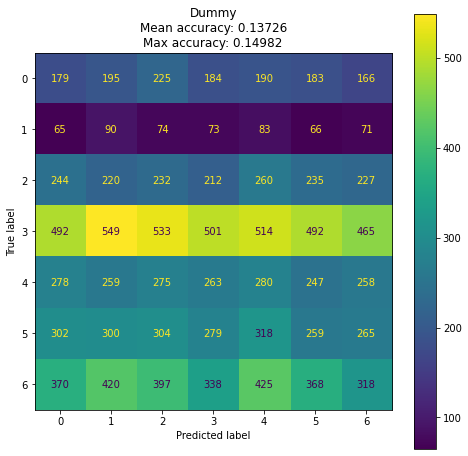

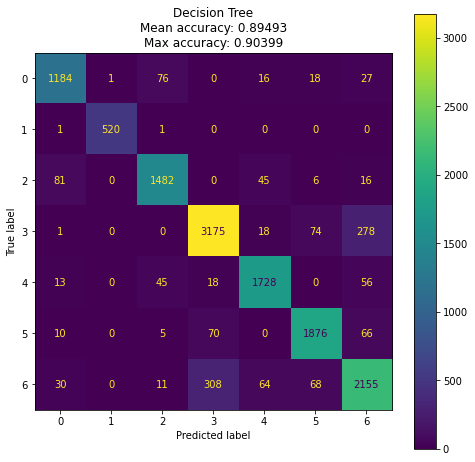

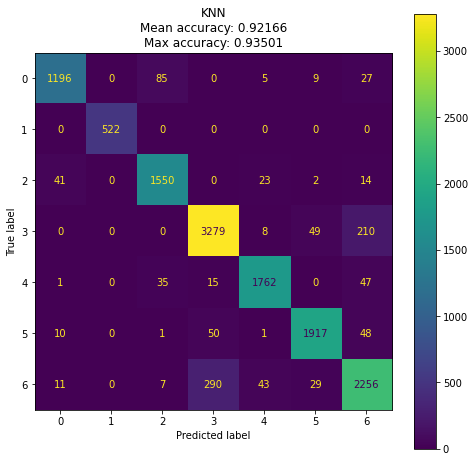

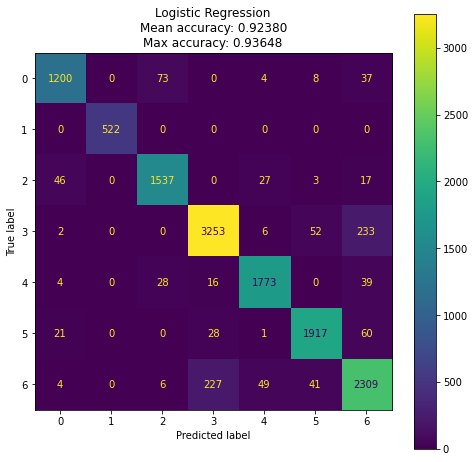

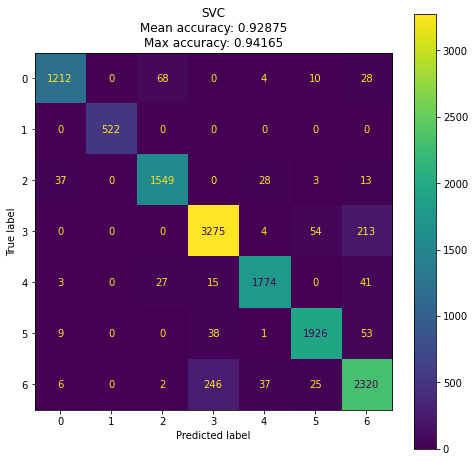

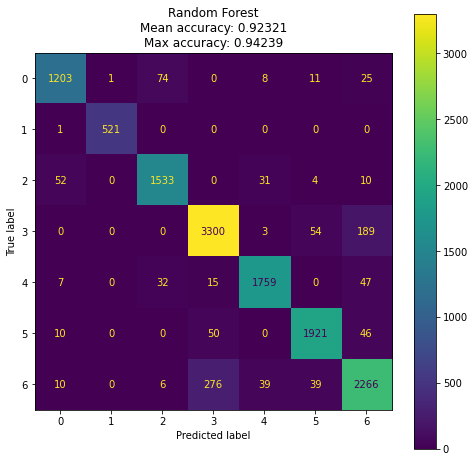

In [213]:
X = df.drop("class", axis=1).copy()
y = df["class"].copy()

cv_split = KFold(n_splits=10, shuffle=True, random_state=randomness_id)

train_evaluate_present(X, y, classifiers, RobustScaler(), cv_split, should_plot=True)

The best results were given by "SVC" classifier with:
Mean accuracy of: 0.92889
Max accuracy of: 0.93501
-------
Following are results for all classifiers:



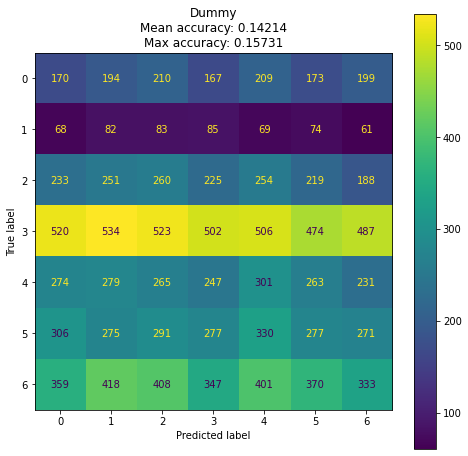

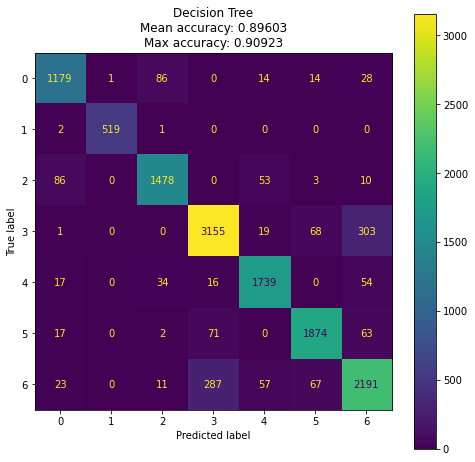

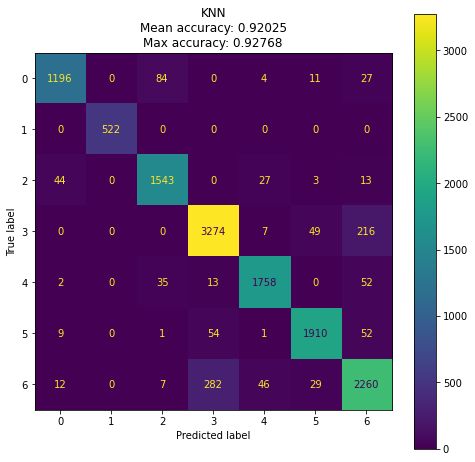

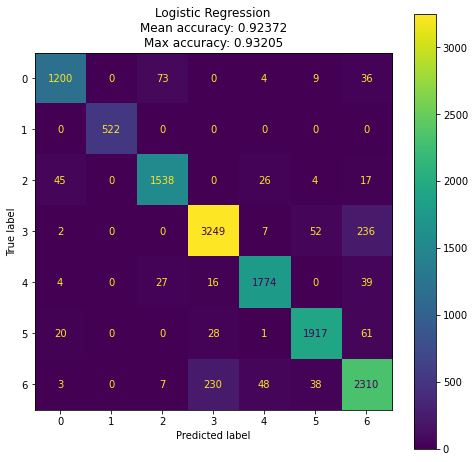

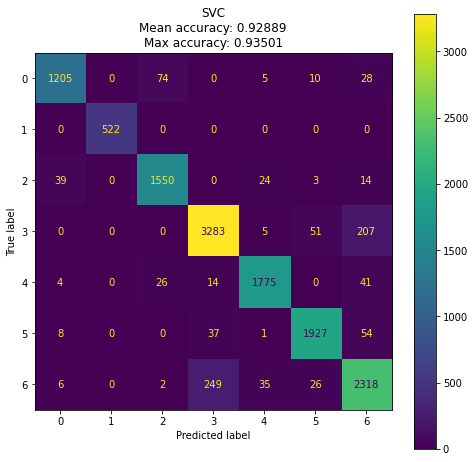

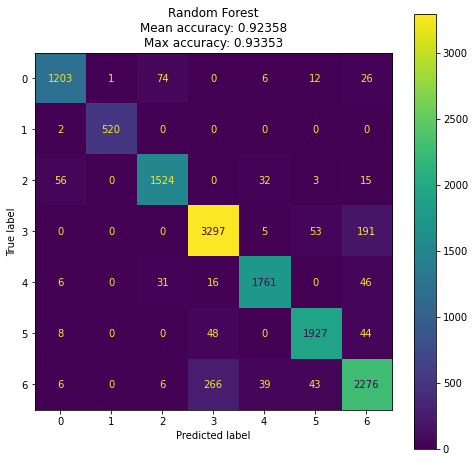

In [214]:
X = df.drop("class", axis=1).copy()
y = df["class"].copy()

cv_split = StratifiedKFold(n_splits=10, shuffle=False)

train_evaluate_present(X, y, classifiers, RobustScaler(), cv_split, should_plot=True)

## Data correlation

<AxesSubplot:>

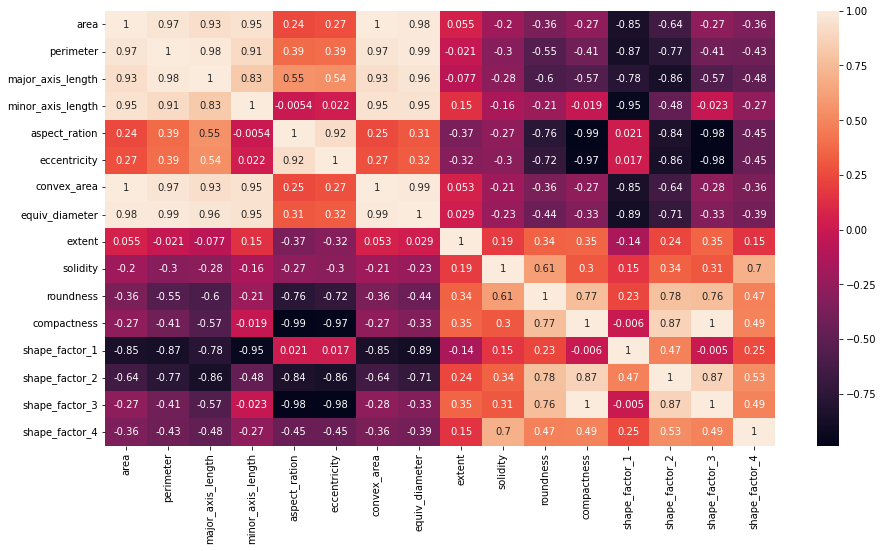

In [215]:
plt.figure(figsize=(15, 8))
sns.heatmap(df.corr(), annot=True)

The best results were given by "SVC" classifier with:
Mean accuracy of: 0.93096
Max accuracy of: 0.93648
-------
Following are results for all classifiers:



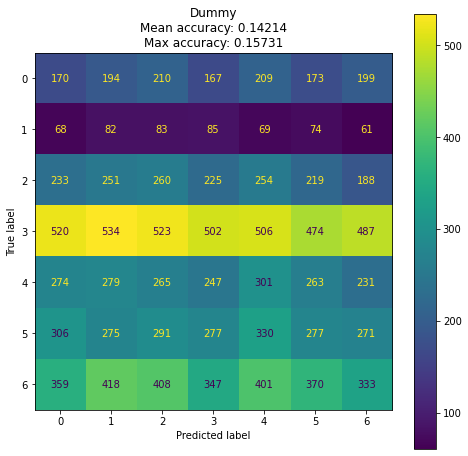

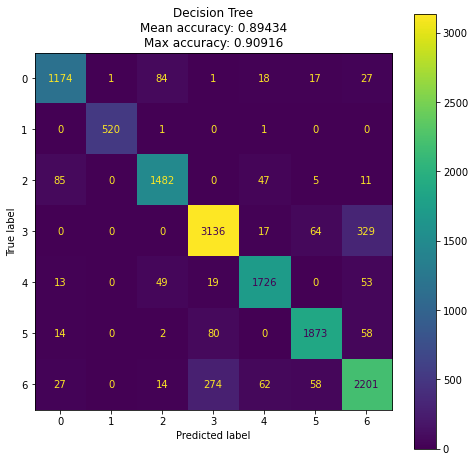

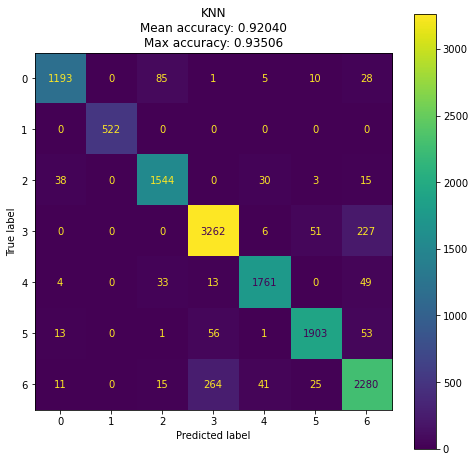

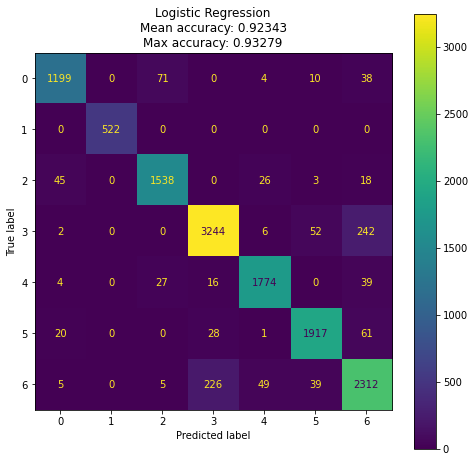

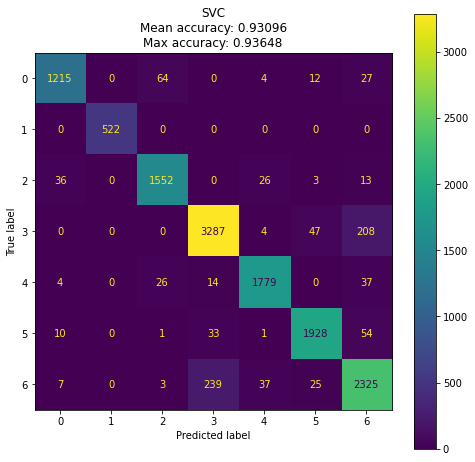

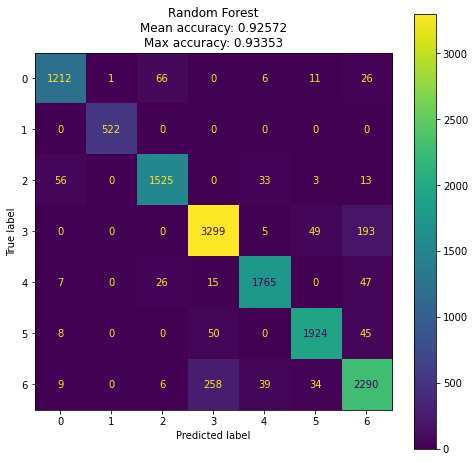

In [216]:
def trim_correlated(df_in, threshold):
    df_corr = df_in.corr(method='pearson', min_periods=1)
    df_not_correlated = ~(df_corr.mask(np.tril(np.ones([len(df_corr)] * 2, dtype=bool))).abs() > threshold).any()
    un_corr_idx = df_not_correlated.loc[df_not_correlated[df_not_correlated.index] == True].index
    df_out = df_in[un_corr_idx]
    return df_out


df_trimmed = pd.concat([trim_correlated(df, 0.95), df["class"]], axis=1)

X = df_trimmed.drop("class", axis=1).copy()
y = df_trimmed["class"].copy()

cv_split = StratifiedKFold(n_splits=10, shuffle=False)

train_evaluate_present(X, y, classifiers, RobustScaler(), cv_split, should_plot=True)